# Chaines de Markov et épidémiologie : propagation d’une épidémie dans une population


L’objectif de ce projet est de manipuler des chaînes de Markov pour étudier la propagation d’une épidémie dans une population.

## Partie 1 : Apprentissage des paramètres d’un modèle à partir de données

Dans notre modèle, nous allons considérer qu’à chaque temps :
- chaque individu sain peut rester sain ou devenir infecté
- chaque individu infecté peut rester infecté ou devenir guéri
- chaque individu guéri reste guéri

et que la probabilité de passer d’un état à l’autre **ne dépend que de l’état précédent**.

Nous disposons d’une séquence d’observations et nous souhaitons apprendre les paramètres de la chaîne de Markov permettant de modéliser le processus sous-jacent qui a généré la séquence.

En suivant un individus pendant 10 on obtient donc la sequence d'observation suivante : $S, S, S, I, I ,I ,I , I, I, R$

On peut donc en deduire la matrice de probabilité de transition suivante :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   | 2/3 |1/3  |0|
|I   | 0 | 5/6 |1/6|
|R   |0    |  0  |1|


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Quelques fonction utlies que nous utiliserons par la suite

#Trace un graphique
def graph(x, y ,titre):
    plt.figure(figsize=(5, 3))
    plt.title(titre)
    plt.plot(x, y[:,0], label='Sain (S)')
    plt.plot(x, y[:,1], label="Infecté (I)")
    plt.plot(x, y[:,2], label="Guéri (R)")
    plt.xlabel("Temps t")
    plt.ylabel("Probabilités des états")
    plt.legend()
    plt.show()


def histogramme(x,y,titre, label):
    fig = plt.figure(figsize=(7, 5))
    plt.title(titre)
    plt.bar(x,y, label = label)
    plt.xlabel("Longueur I")
    plt.ylabel("Nombre d'individus")
    plt.legend()
    plt.show()


def histogramme2(x1,y1, titre, label1, x2,y2, label2):
    fig = plt.figure(figsize=(7, 5))
    plt.title(titre)
    plt.bar(x1-0.3,y1,0.6, label = label1)
    plt.bar(x2+0.3,y2,0.6, label = label2)
    plt.xlabel("Longueur I")
    plt.ylabel("Nombre d'individus")
    plt.legend()
    plt.show()


Nous avons ensuite suivis une population de 5000 individus, pendant 200 jours, et obtenons donc la matrice de probabilité de transitions suivante :

In [3]:
data = np.loadtxt("data_ex1.txt", dtype =int) # Lecture des données

# 0 --> Sain (S)
# 1 --> Infecté (I)
# 2 --> Guéri (R)

def probas(data):
    m = np.zeros((3,3), dtype= float) #Création d'une matrice initialisée à 0
    prec = 9 #Declaration d'une variable précédent


    for individu in data : 
        for state in individu :
            if prec == 9 : #Si c'est la premiere valeur pour un individu on passe au suivant et on le met dans le precedent
                prec = state
                continue
            else : # Sinon on compte la transition dans la matrice m (precedent -> state)
                m[prec][state]+=1
            prec = state
        prec = 9 #A la fin de chaque individu il n'y a plus de precedent

    sum = np.sum(m,axis=1) #On somme toute les lignes
    
    for i in range(3) :
        for j in range(3) :
            m[i][j] = m[i][j]/sum[i] #On chaque case par le nombre total de transition dans une ligne
    
    return m
            


matrice = probas(data)
print(matrice)

[[0.93082918 0.06917082 0.        ]
 [0.         0.93518148 0.06481852]
 [0.04065945 0.         0.95934055]]


## Partie 2 : Description du premier modèle


Grâce au graphe de transition du document 1 on obtient la matrice de transition A suivante :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   |0.92 | 0.08 |  0 |
|I   | 0   | 0.93 |0.07|
|R   |  0  |  0   |  1 |

In [4]:
A = np.array([[.92, .08, .0], [.0, .93, .07], [.0, .0, 1.]])
print(A)

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.   0.   1.  ]]


Verifions si elle est stochastique

In [5]:
def stochastique(matrice) :
    # Verifie si toute les valeurs sont >= 0 et que la sommme de chaque ligne est égale à 1
    return np.all(matrice >= 0 ) and np.all(np.sum(matrice, axis=1)) == 1

print(stochastique(matrice))

True


Au temps $t = 0$, un individu a une probabilité de 0.9 d’être sain et 0.1 d’être infecté.
Soit $\pi_0$ la distribution de la probabilité initiale.

On a donc $\pi_0 = [0.9;0.1;0]$

In [6]:
pi0 = np.array([0.9,0.1,0])
print("pi0 = ",pi0)

pi0 =  [0.9 0.1 0. ]


### Distribution :

Au temps $t = 1$ on a donc $\pi_0 \times A$ donc $\pi_1 = [0.828;0.165;0.007]$

In [7]:
pi1 = np.dot(pi0,A)
print("pi1 =",pi1)

pi1 = [0.828 0.165 0.007]


Au temps $t = 2$ on a donc $\pi_1 \times A$ donc $\pi_2 = [0,76176;0,21969;0,01855]$

In [8]:
pi2 = np.dot(pi1,A)
print("pi2 = ",pi2)

pi2 =  [0.76176 0.21969 0.01855]


Afin de calculer la distribution theorique des effectifs dans chaque états on doit donc calculer $\pi_t$ à chaque temps $t$
On a donc
$$ \pi_{t+1}=\pi_{t}\times A = (\pi_{t-1}\times A)\times A = \pi_0 \times A^t $$

(200, 3)


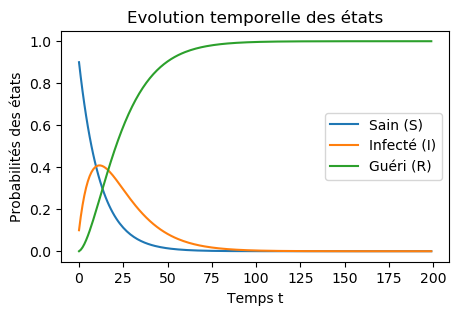

In [9]:
def distribution(pi,a,t):
    # Calcule la distribution théorique suivant un temps t
    return np.matmul(pi,np.linalg.matrix_power(a,t))


T = np.arange(200)
pit = np.zeros((200, 3))
for i in range(0, 200):
    pit[i] = distribution(pi0,A,i)

print(pit.shape)

graph(T, pit,"Evolution temporelle des états")


On observe donc que le taux de personne saine decroit très rapidement suivant le temps, tandis que le taux de de personne guéri croit. Le taux de personnes infectées connait un pic et decroit rapidement.

### Tirage aléatoire des états

Nous allons maintenant générer une séquence de taille T en utilisant cette chaine de Markov. Pour générer cette séquence aléatoire, nous allons choisir un état initial au hasard; puis choisir les états suivants en suivant les probabilités de transition.

In [10]:
def gen_sequences(A,pi, t):
    #Genere une sequence aléatoire pour un individu sur un temps t
    seq = np.zeros(t)
    seq[0] = np.random.choice([0.,1.,2.],1, p = pi)
    for i in range(1,t):
        seq[i] = np.random.choice([0.,1.,2.],1, p=A[int(seq[i-1])])
    return seq

print(gen_sequences(A,pi0,150))



[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]


### Modélisation d'une population

Modélisons maintenant une une séquence d'état pour une population de 200 individus.

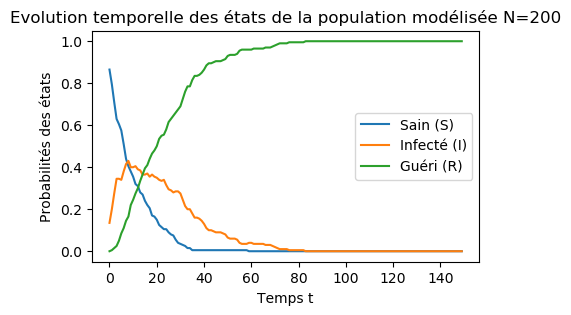

In [11]:
def gen_sequences_population(A,pi,n, t):
    #Genere des sequences aléatoires pour une population de taille n sur un temps t
    seq = np.zeros((n,t))
    for i in range(n):
        seq[i] = gen_sequences(A, pi, t)
    return seq

p=gen_sequences_population(A,pi0,200,150)


def compteur(sequence,t,taille):
    #Compte le nombre de personnes dans chaque état à un temps t
    res = np.zeros((t,3))
    for i in range (len(sequence)):
        for j in range (len(sequence[0])):
            if sequence[i][j] == 0:
                res[j][0]+=1
            if sequence[i][j] == 1:
                res[j][1]+=1
            if sequence[i][j] == 2:
                res[j][2]+=1
    res/=taille
    return res

repartition = compteur(p,150,200)
T = np.arange(150)
graph(T,repartition,"Evolution temporelle des états de la population modélisée N=200")

On remarque donc que quand t est grand le taux de personnes saines et infectées sont nulle tandis que le taux de personnes infectées est au maximum.

Avec une population de taille 5 nous retrouvons le graphe suivant :

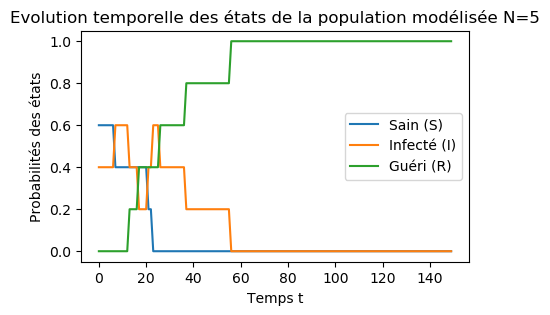

In [12]:
seq5 = gen_sequences_population(A,pi0,5,150)
prop5 = compteur(seq5,150,5)
graph(T, prop5, "Evolution temporelle des états de la population modélisée N=5")

Avec une population de taille 5000 nous retrouvons le graphe suivant :

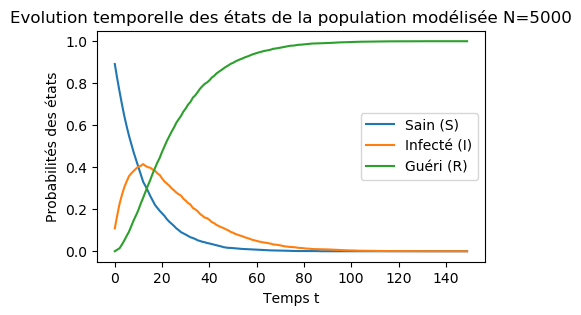

In [13]:
seq5000 = gen_sequences_population(A,pi0,5000,150)
prop5000 = compteur(seq5000,150,5000)

graph(T, prop5000, "Evolution temporelle des états de la population modélisée N=5000")

On remarque que les resultats retrouvés avec une population de taille 5, de taille 200 et de taille 5000 se ressemblent quand t est grand.

### Longueur de l'infection

Estimons maintenant la longueur moyenne d'une infection :

In [14]:
def moyenneI(sequences,t,n):
    #Calcule la longueur moyenne d'une infection

    r = np.count_nonzero(sequences == 1. , axis=1) #Compte pour chaque individus la longueur de sa séquence de I
    res = np.sum(r)/n
    return res

moy = moyenneI(seq5000, 150, 5000)
print("Le temps d'infection moyen sur une population de 5000 individus est donc de :", moy)

Le temps d'infection moyen sur une population de 5000 individus est donc de : 14.4488


[ 5  7  6  6  1 71  3 14 20 30  3  1 20  3 17  3 45  9  5 19 48  4  1  1
  1  2  2 22 24  3 28 16 15 69 10  1  1  1 10  5  9 11  9 11 11 14  2  2
 33  8 32  2 16 12  6 27  4  5 14  7  6 18 12 12  6 11 30 23 25  4 15  2
  8  4 20  2  6  6 33 22 19  5  3  2 13 14 24 21  4 20 12 21 17 20 15 10
 14 28  7 10 18  2 14 13 13  9 11 26 10  1 16  7 38  9 16  2 31  3  9 14
  3 17 15  5  9 17 18 55 39  9  3  4  7 18  2 13  1  6 12  4 66  6  2 50
 28 23  1 20  3  2  4 52  5 21 12 20  4 16 21 49 27 13  3  7 13  7 16  4
 18  3 10  5  8  1 37  6  1  8 15  3 20 25 18 12  7 22 13  4 27 10 15 66
 16  5 15  2  8  3 10 35]


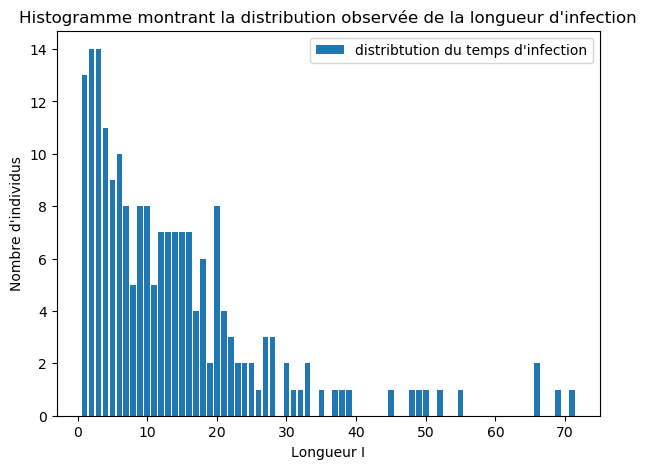

In [15]:
a = np.count_nonzero(p == 1. , axis=1)
print(a)
val , indices = np.unique(a, return_counts=True)
histogramme(val, indices, "Histogramme montrant la distribution observée de la longueur d'infection", "distribtution du temps d'infection")

Calculons maintenant la longueur théorique d'une séquence de I.

La probabilité pour que le temps d'infection soit égal à 1 est de $P(L == 1) = P(IR)$

La probabilité pour que le temps d'infection soit égal à 2 est de $P(L == 2) = P(IIR) = P(II)\times P(IR)$

Notons alors $P(IR) = p$

Donc on a pour un temp le temps d'infection est égal a $P(L == t) = P(II)^{t-1} \times p$

Cela correspond donc a une loi geometrique de probabilité p = 0.07

La longueur théorique d'une séquence de I pour t = 1 est donc de : 14.285714285714285
13.285714285714285
(200,)


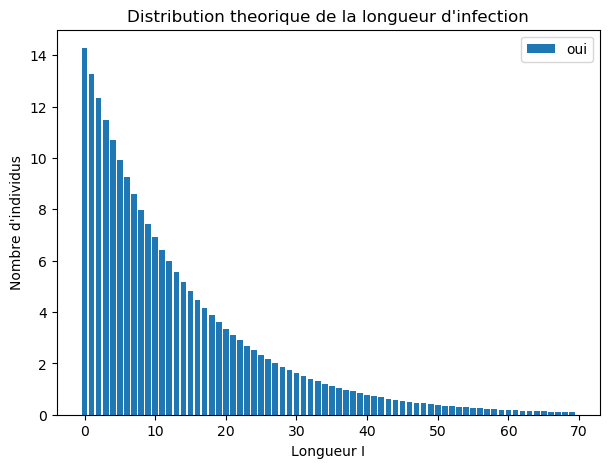

In [16]:
p = A[1][2]

print("La longueur théorique d'une séquence de I pour t = 1 est donc de :",1/p)

longueur_i = np.zeros_like(a, dtype= float)
for i in range (0,len(a)):
    longueur_i[i] = (1-p)**i*(1/p)
print(longueur_i[1])
print(longueur_i.shape)


L = np.arange(70)
histogramme(L, longueur_i[:70],"Distribution theorique de la longueur d'infection","oui")

Comparons alors ces deux distributions.

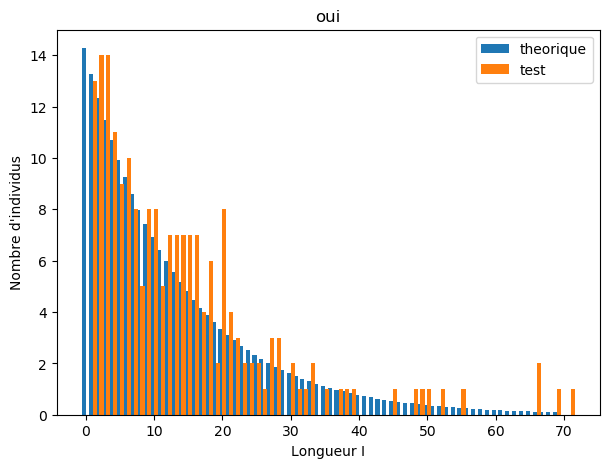

In [17]:
histogramme2(L, longueur_i[:70],"oui","theorique",val,indices,"test")

On remarque donc que les deux distribution ce ressemeblent plus la longueur de I est grande moins ils y d'individus dans ces cas.

# Modification autour de ce premier modèle
Modifions alors la taille de la population et observons 

Le temps d'infection moyen sur une population de 5 individus est donc de : 19.6
Le temps d'infection moyen sur une population de 50 individus est donc de : 12.32
Le temps d'infection moyen sur une population de 100 individus est donc de : 14.06
Le temps d'infection moyen sur une population de 500 individus est donc de : 13.568
Le temps d'infection moyen sur une population de 1000 individus est donc de : 14.287
Le temps d'infection moyen sur une population de 1000 individus est donc de : 13.8894


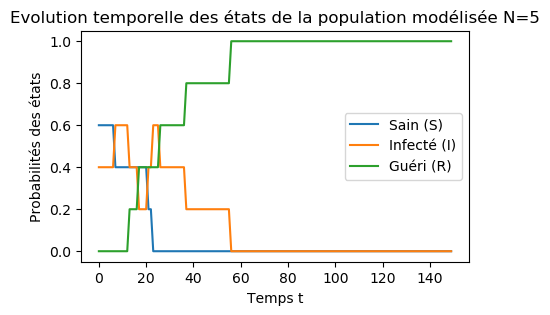

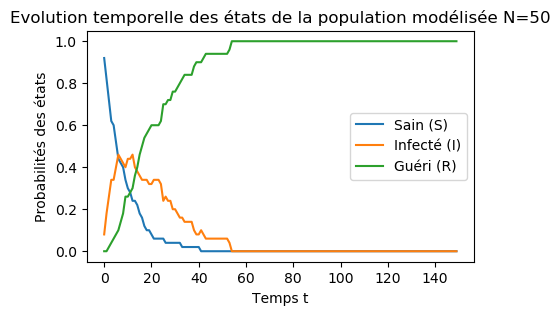

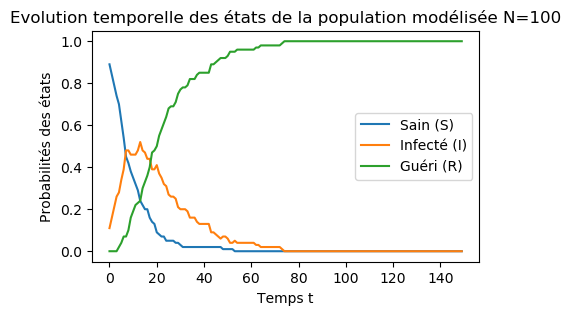

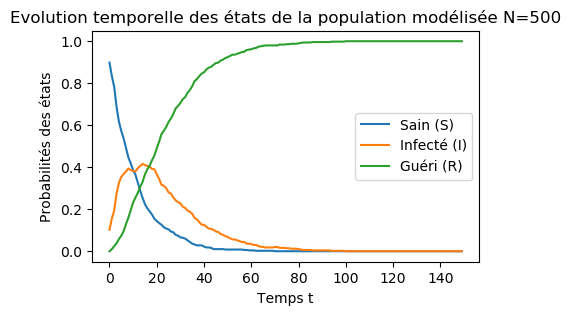

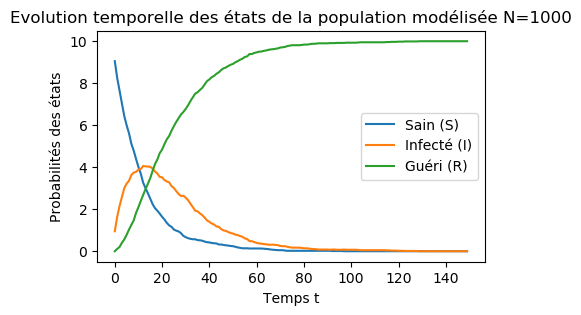

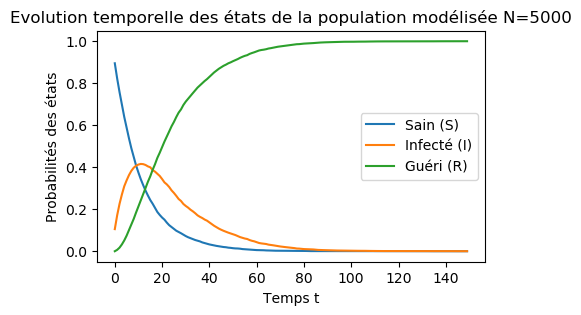

In [18]:
moy5 = moyenneI(seq5, 150, 5)
print("Le temps d'infection moyen sur une population de 5 individus est donc de :", moy5)

seq50 = gen_sequences_population(A,pi0,50,150)
prop50 = compteur(seq50,150,50)
moy50 = moyenneI(seq50, 150, 50)
print("Le temps d'infection moyen sur une population de 50 individus est donc de :", moy50)

seq100 = gen_sequences_population(A,pi0,100,150)
prop100 = compteur(seq100,150,100)
moy100 = moyenneI(seq100, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100)

seq500 = gen_sequences_population(A,pi0,500,150)
prop500 = compteur(seq500,150,500)
moy500 = moyenneI(seq500, 150, 500)
print("Le temps d'infection moyen sur une population de 500 individus est donc de :", moy500)

seq1000 = gen_sequences_population(A,pi0,1000,150)
prop1000 = compteur(seq1000,150,100)
moy1000 = moyenneI(seq1000, 150, 1000)
print("Le temps d'infection moyen sur une population de 1000 individus est donc de :", moy1000)

seq5000 = gen_sequences_population(A,pi0,5000,150)
prop5000 = compteur(seq5000,150,5000)
moy5000 = moyenneI(seq5000, 150, 5000)
print("Le temps d'infection moyen sur une population de 1000 individus est donc de :", moy5000)


graph(T, prop5,"Evolution temporelle des états de la population modélisée N=5" )
graph(T, prop50,"Evolution temporelle des états de la population modélisée N=50" )
graph(T, prop100,"Evolution temporelle des états de la population modélisée N=100" )
graph(T, prop500,"Evolution temporelle des états de la population modélisée N=500" )
graph(T, prop1000,"Evolution temporelle des états de la population modélisée N=1000" )
graph(T, prop5000,"Evolution temporelle des états de la population modélisée N=5000" )

On remarque donc que plus la population est grande plus la probabilité des état va se rapprocher de celle theorique. j'dsdfghdgfghsdfjqlkghfdqsjklghfdqjklm


Modifions maintenant la probabilité initial $\pi_0$

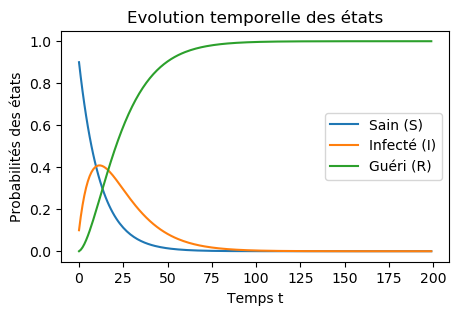

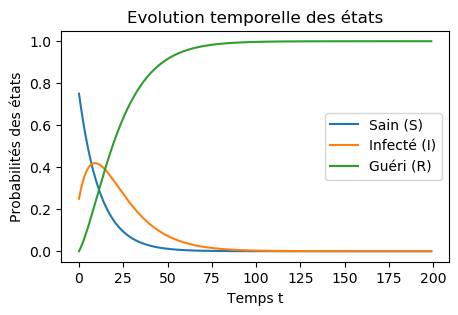

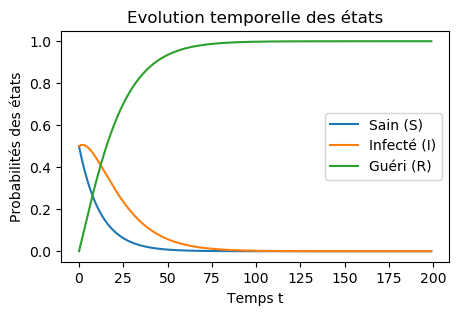

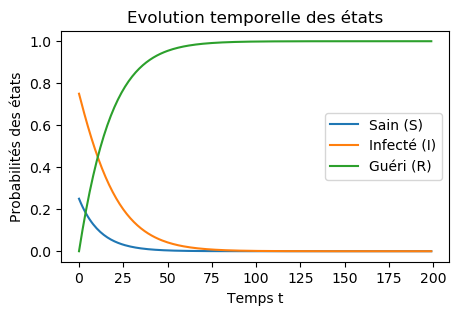

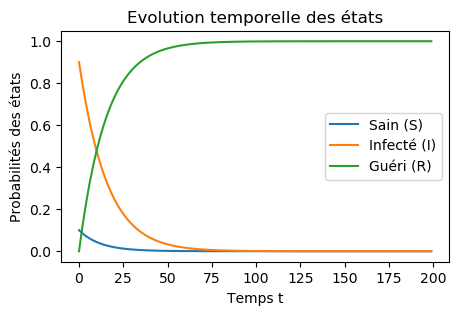

In [19]:
pi0a = np.array([0.9,0.1,0])
pi0b = np.array([0.75,0.25,0])
pi0c = np.array([0.5,0.5,0])
pi0d = np.array([0.25,0.75,0])
pi0e = np.array([0.1,0.9,0])

T = np.arange(200)

pita = np.zeros((200, 3))
for i in range(0, 200):
    pita[i] = distribution(pi0a,A,i)
graph(T, pita,"Evolution temporelle des états")

pitb = np.zeros((200, 3))
for i in range(0, 200):
    pitb[i] = distribution(pi0b,A,i)
graph(T, pitb,"Evolution temporelle des états")

pitc = np.zeros((200, 3))
for i in range(0, 200):
    pitc[i] = distribution(pi0c,A,i)
graph(T, pitc,"Evolution temporelle des états")

pitd = np.zeros((200, 3))
for i in range(0, 200):
    pitd[i] = distribution(pi0d,A,i)
graph(T, pitd,"Evolution temporelle des états")

pite = np.zeros((200, 3))
for i in range(0, 200):
    pite[i] = distribution(pi0e,A,i)
graph(T, pite,"Evolution temporelle des états")




Le temps d'infection moyen sur une population de 100 individus est donc de : 13.96
Le temps d'infection moyen sur une population de 100 individus est donc de : 14.79
Le temps d'infection moyen sur une population de 100 individus est donc de : 12.85
Le temps d'infection moyen sur une population de 100 individus est donc de : 14.19
Le temps d'infection moyen sur une population de 100 individus est donc de : 15.87


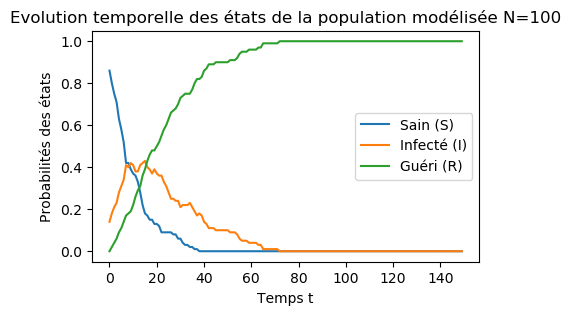

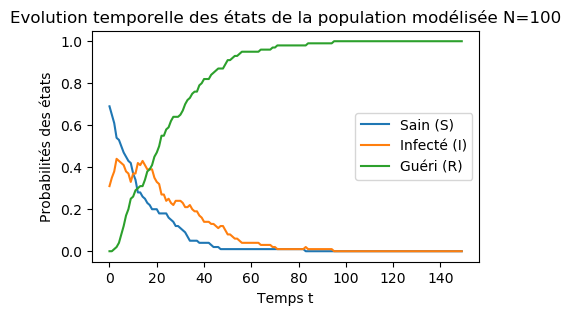

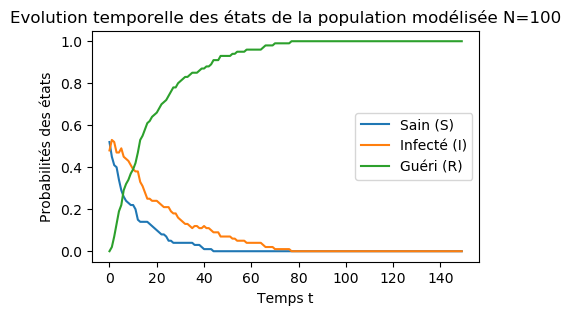

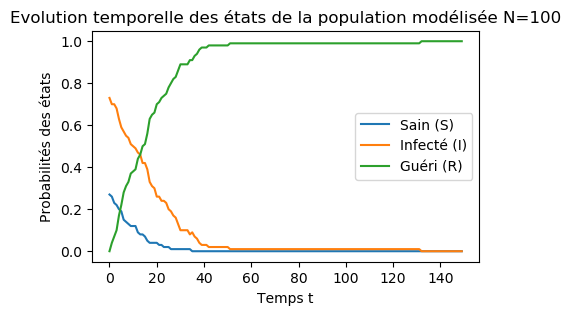

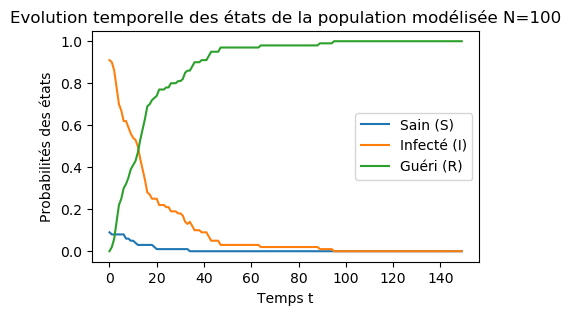

In [20]:
T = np.arange(150)

seq100a = gen_sequences_population(A,pi0a,100,150)
prop100a = compteur(seq100a,150,100)
moy100a = moyenneI(seq100a, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100a)

seq100b = gen_sequences_population(A,pi0b,100,150)
prop100b = compteur(seq100b,150,100)
moy100b = moyenneI(seq100b, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100b)

seq100c = gen_sequences_population(A,pi0c,100,150)
prop100c = compteur(seq100c,150,100)
moy100c = moyenneI(seq100c, 150, 100)

print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100c)
seq100d = gen_sequences_population(A,pi0d,100,150)
prop100d = compteur(seq100d,150,100)
moy100d = moyenneI(seq100d, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100d)

seq100e = gen_sequences_population(A,pi0e,100,150)
prop100e = compteur(seq100e,150,100)
moy100e = moyenneI(seq100e, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100e)



graph(T, prop100a,"Evolution temporelle des états de la population modélisée N=100" )
graph(T, prop100b,"Evolution temporelle des états de la population modélisée N=100" )
graph(T, prop100c,"Evolution temporelle des états de la population modélisée N=100" )
graph(T, prop100d,"Evolution temporelle des états de la population modélisée N=100" )
graph(T, prop100e,"Evolution temporelle des états de la population modélisée N=100" )

j'comprends pas l'interet .-.



Modifions maintenant les probabilités de transitions :

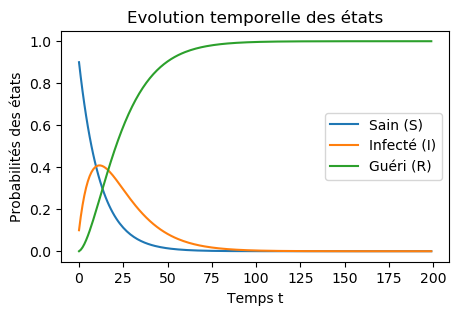

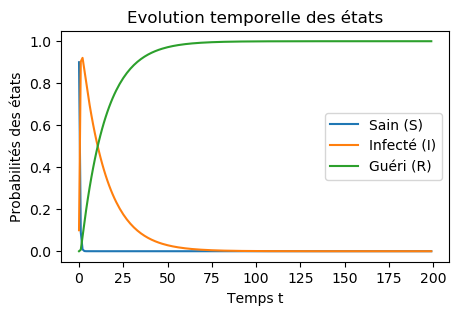

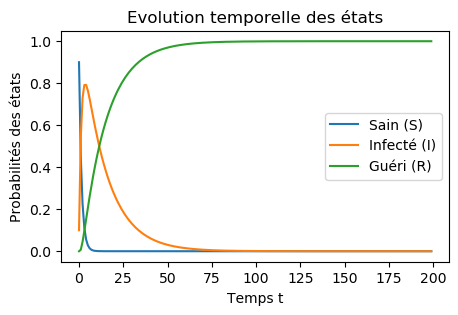

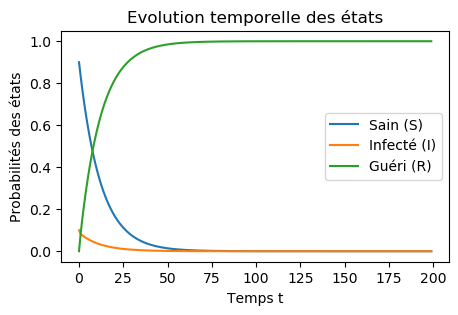

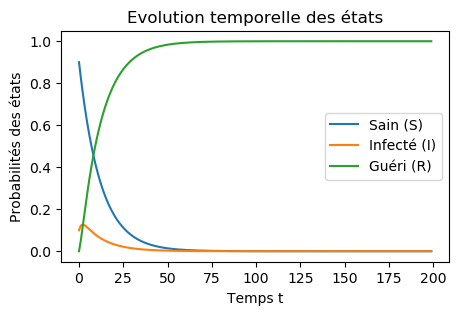

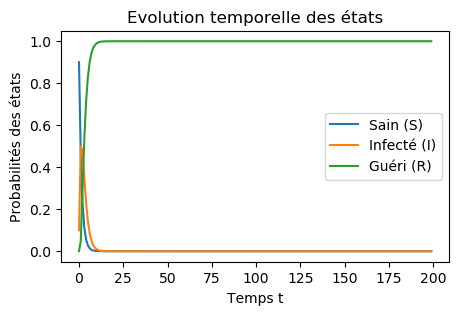

In [21]:
A = np.array([[0.92,0.08,0],[0,0.93,0.07],[0,0,1]])
B = np.array([[0.1,0.9,0],[0,0.93,0.07],[0,0,1]])
C = np.array([[0.5,0.5,0],[0,0.93,0.07],[0,0,1]])
D = np.array([[0.92,0.08,0],[0,0.1,0.9],[0,0,1]])
E = np.array([[0.92,0.08,0],[0,0.5,0.5],[0,0,1]])
F = np.array([[0.5,0.5,0],[0,0.5,0.5],[0,0,1]])


T = np.arange(200)

pit = np.zeros((200, 3))
for i in range(0, 200):
    pit[i] = distribution(pi0,A,i)
graph(T, pit,"Evolution temporelle des états")

pit = np.zeros((200, 3))
for i in range(0, 200):
    pit[i] = distribution(pi0,B,i)
graph(T, pit,"Evolution temporelle des états")

pit = np.zeros((200, 3))
for i in range(0, 200):
    pit[i] = distribution(pi0,C,i)
graph(T, pit,"Evolution temporelle des états")

pit = np.zeros((200, 3))
for i in range(0, 200):
    pit[i] = distribution(pi0,D,i)
graph(T, pit,"Evolution temporelle des états")

pit = np.zeros((200, 3))
for i in range(0, 200):
    pit[i] = distribution(pi0,E,i)
graph(T, pit,"Evolution temporelle des états")

pit = np.zeros((200, 3))
for i in range(0, 200):
    pit[i] = distribution(pi0,F,i)
graph(T, pit,"Evolution temporelle des états")



j'comprends tjr pas l'interet .-.


## Partie 3 : Description du second modèle

# Analyse du modèle
Etudions maintenant un second modele

Ce modèle peut etre modélisé par une chaine de Markov en effet chaque état dépend de l'état du precedent.

Grace au diagramme de transition on obtient donc la matrice de transition suivante :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   | 0.92 | 0.8 |0|
|I   | 0 | 0.93 |0.07|
|R   |  0.02 |  0  |0.98|


Question 3 : 
Les états sont tous communiquant entre eux, est aperiodique car il existe une boucle sur lui meme à chaque état, c'est irreductible

In [22]:
A = np.array([[.92, .08, .0], [.0, .93, .07], [.02, .0, .98]])
print(A)
A2 = np.matmul(A,A)
print(A2)
print(stochastique(A2))
A3 = np.matmul(A2,A)
print(A3)
print(stochastique(A3))
A4 = np.matmul(A3,A)
print(A4)
print(stochastique(A4))

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]]
[[0.8464 0.148  0.0056]
 [0.0014 0.8649 0.1337]
 [0.038  0.0016 0.9604]]
True
[[0.7788   0.205352 0.015848]
 [0.003962 0.804469 0.191569]
 [0.054168 0.004528 0.941304]]
True
[[0.71681296 0.25328136 0.02990568]
 [0.00747642 0.74847313 0.24405045]
 [0.06866064 0.00854448 0.92279488]]
True


$A^2 :$
jsp a quoi ca correspond .-.
oui stochastique

$A^3 :$
jsp a quoi ca correspond .-.
oui stochastique

$A^4 :$
jsp a quoi ca correspond .-.
oui stochastique


==> toutes les matrices $A²$, $A^3$; $A^4$ sont récurent et stochastique

Realisons maintenant les memes experiences avec cette fois ci la nouvelle matrice de transition :
Prenons au temps t = 0 un population où tous les individus sont sains
on a alors $\pi_0 = [1,0,0]$

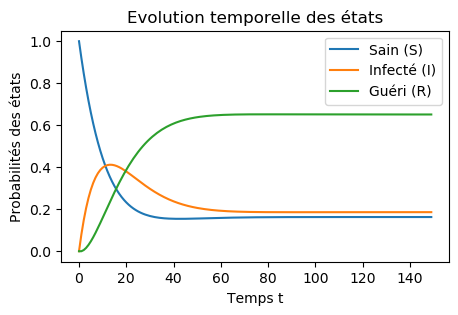

In [23]:
A = np.array([[.92, .08, .0], [.0, .93, .07], [.02, .0, .98]])
pi0 = np.array([1,0,0])

T = np.arange(150)
pit = np.zeros((150, 3))
for i in range(0, 150):
    pit[i] = distribution(pi0,A,i)
graph(T, pit,"Evolution temporelle des états")

On remarque donc qu'au bout d'un moment le taux d'individus dans chaque état stagne, le taux d'individus guéris à 0.6, et le taux d'individus infectés et sains à 0.2

Effectuons cette experience sur une population de taille 5, 50, 100, 500, 1000, 5000

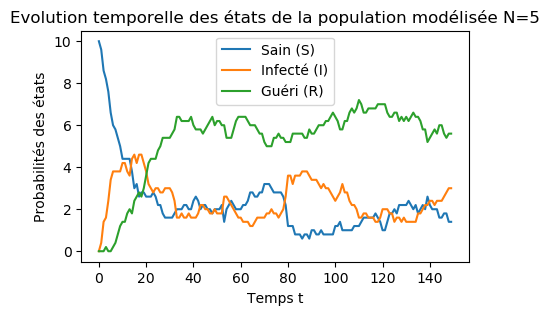

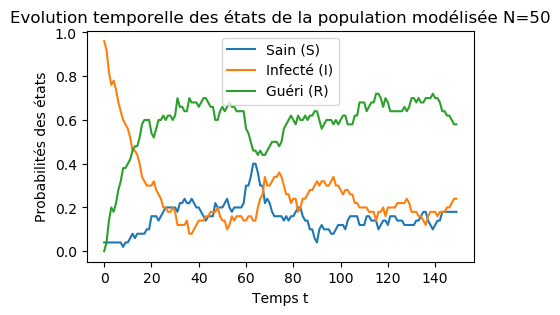

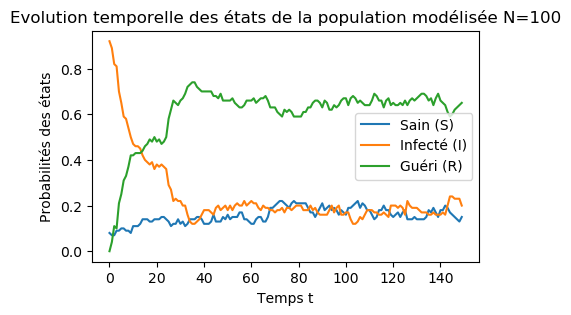

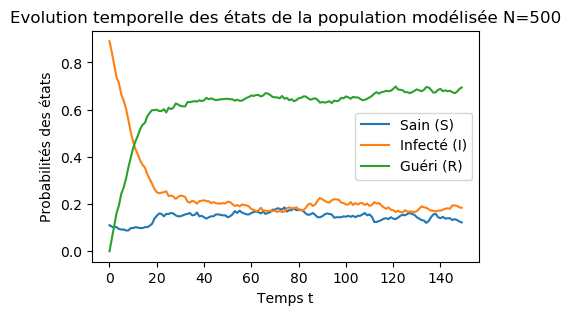

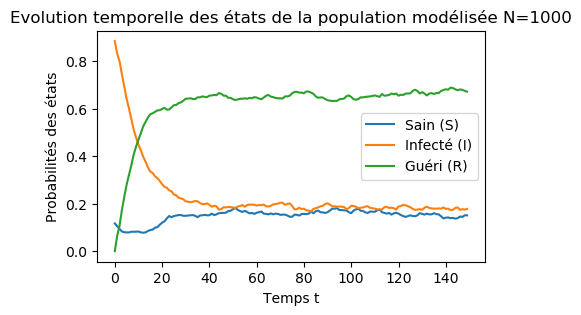

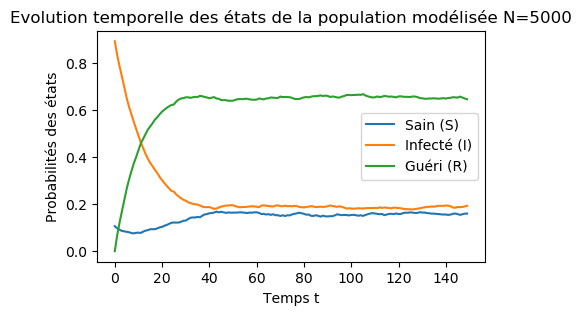

In [46]:
T = np.arange(150)

seq5 = gen_sequences_population(A,pi0,5,150)
prop5 = compteur(seq50,150,5)

seq50 = gen_sequences_population(A,pi0,50,150)
prop50 = compteur(seq50,150,50)

seq100 = gen_sequences_population(A,pi0,100,150)
prop100 = compteur(seq100,150,100)

seq500 = gen_sequences_population(A,pi0,500,150)
prop500 = compteur(seq500,150,500)

seq1000 = gen_sequences_population(A,pi0,1000,150)
prop1000 = compteur(seq1000,150,1000)

seq5000 = gen_sequences_population(A,pi0,5000,150)
prop5000 = compteur(seq5000,150,5000)


graph(T, prop5,"Evolution temporelle des états de la population modélisée N=5" )
graph(T, prop50,"Evolution temporelle des états de la population modélisée N=50" )
graph(T, prop100,"Evolution temporelle des états de la population modélisée N=100" )
graph(T, prop500,"Evolution temporelle des états de la population modélisée N=500" )
graph(T, prop1000,"Evolution temporelle des états de la population modélisée N=1000" )
graph(T, prop5000,"Evolution temporelle des états de la population modélisée N=5000" )

jsp c'qu'on peut conclure de ca .-.


Changeons maintenant l'etat de la population au temps t = 0 prenons $ \pi = [0.1,0.9,0]$

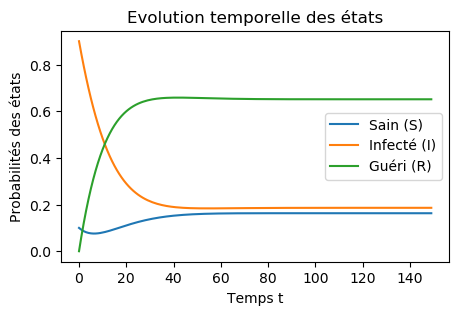

In [25]:
pi0 = np.array([.1,.9,0])

T = np.arange(150)
pit = np.zeros((150, 3))
for i in range(0, 150):
    pit[i] = distribution(pi0,A,i)
graph(T, pit,"Evolution temporelle des états")

En changeant la répartition des individus dans chaque état on observe que les courbes reviennent dans le meme état

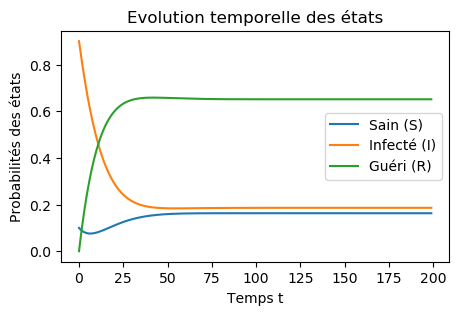

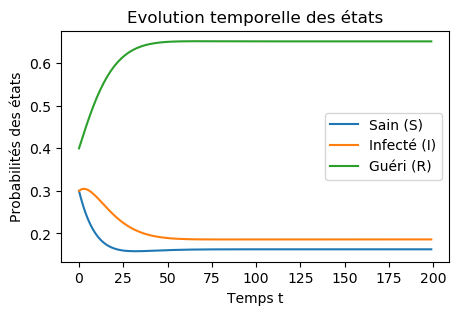

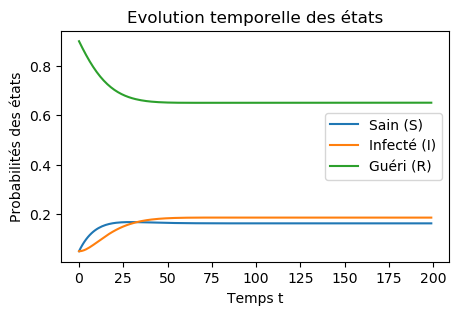

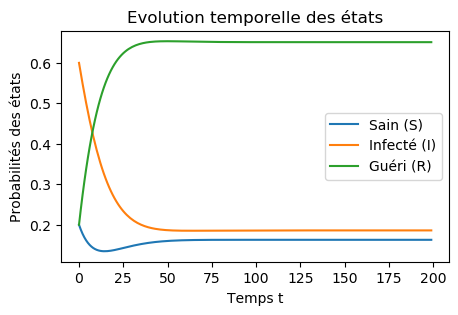

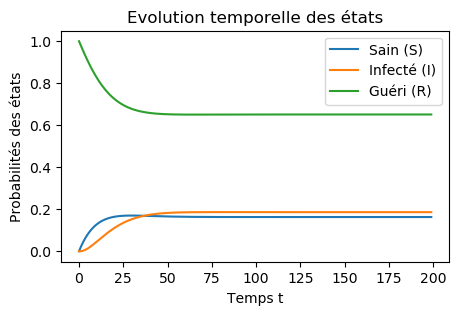

In [26]:
pi0a = np.array([0.1,0.9,0])
pi0b = np.array([0.3,0.3,0.4])
pi0c = np.array([0.05,0.05,0.9])
pi0d = np.array([0.20,0.60,0.20])
pi0e = np.array([0,0,1])

T = np.arange(200)

pita = np.zeros((200, 3))
for i in range(0, 200):
    pita[i] = distribution(pi0a,A,i)
graph(T, pita,"Evolution temporelle des états")

pitb = np.zeros((200, 3))
for i in range(0, 200):
    pitb[i] = distribution(pi0b,A,i)
graph(T, pitb,"Evolution temporelle des états")

pitc = np.zeros((200, 3))
for i in range(0, 200):
    pitc[i] = distribution(pi0c,A,i)
graph(T, pitc,"Evolution temporelle des états")

pitd = np.zeros((200, 3))
for i in range(0, 200):
    pitd[i] = distribution(pi0d,A,i)
graph(T, pitd,"Evolution temporelle des états")

pite = np.zeros((200, 3))
for i in range(0, 200):
    pite[i] = distribution(pi0e,A,i)
graph(T, pite,"Evolution temporelle des états")


Pour retrouver la distribution de probabilité stationnaire on recherche un $\pi_t$ tel que $\pi_t = \pi_{-1}\times A$ 


In [27]:
An_1 = np.zeros_like(A)
An = A.copy()

def stationnaire(A, pi0):
    i=0
    An_1 = np.zeros_like(A)
    An = A.copy()
    while not np.all(An == An_1):
        An_1 = An.copy()
        An = np.matmul(pi0,np.linalg.matrix_power(A,i))
        i+=1
    return An

print("La distribution de probabilités stationnaire est", stationnaire(A,pi0))

La distribution de probabilités stationnaire est [0.1627907  0.18604651 0.65116279]


On remarque qu'avec t assez grand le taux d'individus guéris, sains et inféctés corresponds à la distribution de probabilits stationnaire.

# Longueur d'immunité

On peut se demander combien de temps un individu qui a été malade, reste protégé contre la maladie.

Calculons alors la longueur théorique d'une séquence de R.

In [45]:
def nbR(p):
    repR = 0
    nbR = []
    for j in p:
        for i in j:
            if i == 2:
                repR += 1
            if i != 2 and repR != 0:
                nbR.append( repR )
                repR = 0 
    return np.sum(nbR)/len(nbR)

print(nbR(seq5000))

36.28460155781905


^ moyenne sur une simulation